In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wvs = pd.read_csv('../raw_data/WVS_TimeSeries_4_0.csv')

## Problem Statement ##

The rise of authoritarianism is a growing concern among democratic societies worldwide. To gain and maintain power, authoritarian leaders require a base of followers who support their ideology and policies. In this project, I aim to predict support for authoritarianism using data from the World Values Survey dataset. This dataset includes responses from individuals in various countries regarding their attitudes towards governance, society, and culture. By analyzing the WVS dataset using machine learning models, I seek to identify factors that contribute to support for authoritarianism, such as economic insecurity, cultural conservatism, and distrust of institutions. The results of this project could provide insights into the underlying causes of authoritarianism and inform strategies to prevent its spread in democratic societies.

In [3]:
wvs.head()

,version,doi,S002VS,S003,COUNTRY_ALPHA,COW_NUM,COW_ALPHA,S004,S006,S007,...,Y023A,Y023B,Y023C,Y024A,Y024B,Y024C,survself,tradrat5,TradAgg,SurvSAgg
0,4-0-0,doi:10.14281/18241.22,4,8,ALB,339,ALB,-4,1,80420001,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4-0-0,doi:10.14281/18241.22,4,8,ALB,339,ALB,-4,2,80420002,...,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4-0-0,doi:10.14281/18241.22,4,8,ALB,339,ALB,-4,3,80420003,...,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4-0-0,doi:10.14281/18241.22,4,8,ALB,339,ALB,-4,4,80420004,...,0.333333,1.0,0.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4-0-0,doi:10.14281/18241.22,4,8,ALB,339,ALB,-4,5,80420005,...,0.000000,0.0,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
wvs.shape

(450869, 1045)

In [5]:
wvs.COUNTRY_ALPHA.value_counts()

ZAF    16786
USA    12983
IND    12621
COL    12082
MEX    11714
       ...  
FRA     1001
PSE     1000
YEM     1000
NIR      447
DOM      417
Name: COUNTRY_ALPHA, Length: 108, dtype: int64

In [6]:
wvs.columns

Index(['version', 'doi', 'S002VS', 'S003', 'COUNTRY_ALPHA', 'COW_NUM',
       'COW_ALPHA', 'S004', 'S006', 'S007',
       ...
       'Y023A', 'Y023B', 'Y023C', 'Y024A', 'Y024B', 'Y024C', 'survself',
       'tradrat5', 'TradAgg', 'SurvSAgg'],
      dtype='object', length=1045)

There are a number of pre-engineered aggregate variables at the end of the dataset. Each of these has the prefix 'Y'. I'm not inclined to use them in my models because the literature on which questions they aggregate, and the methodology for doing so, isn't great. There also seems to be a fair number of null values. As I searched through these, I was somewhat interested in variable **Y011A**, which is described in the data dictionary as "AUTHORITY". After some further digging, however, I discovered that this statistic is meant to measure the respondents defiance of authority, rather than inclination towards authoritarian values. 

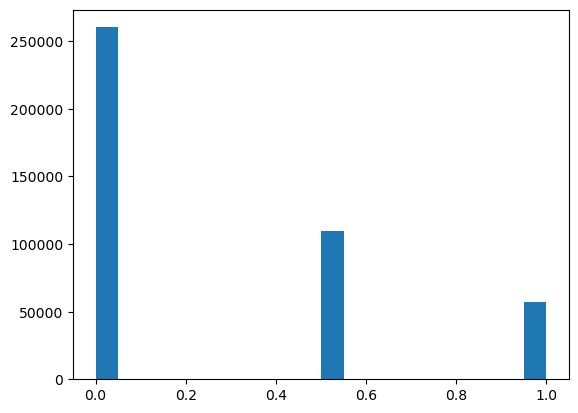

In [7]:
plt.hist(wvs['Y011A'], bins=20);

In [8]:
wvs.Y011A.isna().sum()

23714

The data for the survey has thus far been collected in seven waves, with each wave taking a few years to complete. The questions asked and the countries participating have changed and expanded over the course of each successive wave. Variable **S002VS** indicates the wave during which each interview was conducted:

In [9]:
wvs['S002VS'].value_counts(dropna=False).sort_index()

1    14840
2    29174
3    77818
4    60045
5    85149
6    89565
7    94278
Name: S002VS, dtype: int64

My initial plan was to create time series data by aggregating by year and country all the way back to the first wave, which started in 1981. One quick look at variable **S020**, which indicates the year in which each interview was conducted, shows why this won't be possible. There are big gaps in time between waves 1 and 2 (1985-1988), as well as between waves 2 and 3 (1992-1994).

Luckily, this issue dissapates thereafter, with successive waves following wave 3 starting almost as soon as the previous wave completes. As a result, I should be able to create my time series data starting with the first year of wave 3 in 1995. Starting with wave 3 does have some additional benefits, as wave 3 marked a significant expansion in the scope of the survey both in terms of the questions asked and the countries included.  

There is still a one year gap in 2015. Once I have the data in the shape I want it I'll consider various methods of interpolation in order to fill the gap

In [10]:
wvs['S020'].value_counts(sort=False).sort_index()

1981     8551
1982     5284
1984     1005
1989     2338
1990    23128
1991     3708
1995    16681
1996    32321
1997    14167
1998    13395
1999     4749
2000    12991
2001    32387
2002     6302
2003     2545
2004     4279
2005    17437
2006    36513
2007    22513
2008     3051
2009     3681
2010     5702
2011    25012
2012    28896
2013    17437
2014    10522
2016     1996
2017     9722
2018    40647
2019     7007
2020    21187
2021     5918
2022     9797
Name: S020, dtype: int64

I'll start constructing the dataset for my time series model by removing interviews collected prior to 1995

In [11]:
wvs_ts = wvs[wvs['S020'] >= 1995].copy()
wvs_ts.shape

(406855, 1045)

Here is a list of countries included in the data starting with wave 3

In [12]:
wvs_ts['COUNTRY_ALPHA'][wvs_ts['S002VS'] == 3].value_counts().sort_index()

ALB     999
ARG    1079
ARM    2000
AUS    2048
AZE    2002
BGD    1525
BGR    1072
BIH    1200
BLR    2092
BRA    1143
CHE    1212
CHL    1000
CHN    1500
COL    6025
CZE    1147
DEU    2026
DOM     417
ESP    1211
EST    1021
FIN     987
GBR    1093
GEO    2008
HRV    1196
HUN     650
IND    2040
JPN    1054
KOR    1249
LTU    1009
LVA    1200
MDA     984
MEX    1510
MKD     995
MNE     240
NGA    1996
NOR    1127
NZL    1201
PAK     733
PER    1211
PHL    1200
POL    1153
PRI    1164
ROU    1239
RUS    2040
SLV    1254
SRB    1280
SVK    1095
SVN    1007
SWE    1009
TUR    1907
TWN     780
UKR    2811
URY    1000
USA    1542
VEN    1200
ZAF    2935
Name: COUNTRY_ALPHA, dtype: int64

## Sorting Countries Into Regions

Unfortunately, I'm discovering that when breaking things down to the country level there are more gaps year by year, with most countries completing their interviews for each wave in a single year, and some countries not involved in every wave. In order to create a dataset I can use for time series I'll need to group the countries into **regions**, so that I have data for every year. 

In [13]:
def waves_years(country_code):
    country_df = wvs_ts[['COUNTRY_ALPHA', 'S002VS', 'S020']][wvs_ts['COUNTRY_ALPHA'] == country_code]
    unique_values = country_df.drop_duplicates(subset = 'S020').sort_values(by='S020')
    return unique_values

In [14]:
waves_years('ROU')

,COUNTRY_ALPHA,S002VS,S020
303153,ROU,3,1998
299874,ROU,5,2005
301650,ROU,6,2012
304392,ROU,7,2018


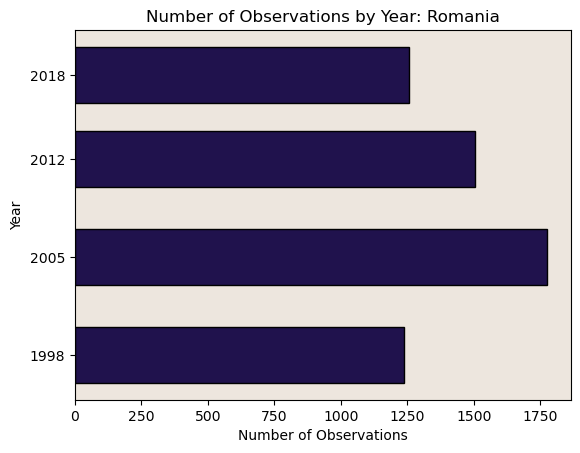

In [60]:
wvs_ts_rou = wvs_ts[wvs_ts['COUNTRY_ALPHA'] == 'ROU']
year_counts = wvs_ts_rou['S020'].value_counts()

plt.barh(year_counts.index, year_counts.values, height=4, color='#20124d', edgecolor='black')

plt.gca().set_facecolor('#ede6de')

plt.xlabel('Number of Observations')
plt.ylabel('Year')
plt.title('Number of Observations by Year: Romania')

plt.yticks(year_counts.index);

In [15]:
waves_years('USA')

,COUNTRY_ALPHA,S002VS,S020
428996,USA,3,1995
427796,USA,4,1999
426547,USA,5,2006
424315,USA,6,2011
434702,USA,7,2017


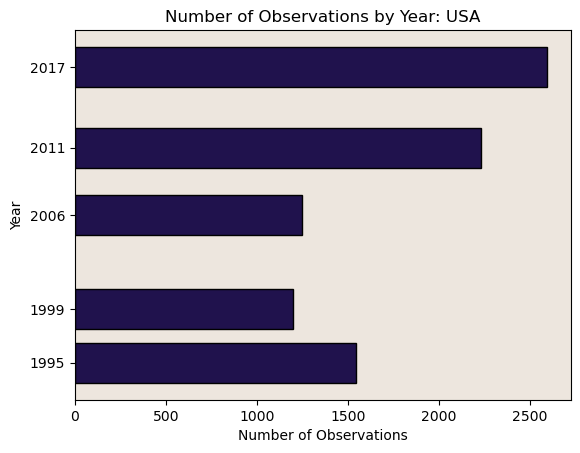

In [58]:
wvs_ts_usa = wvs_ts[wvs_ts['COUNTRY_ALPHA'] == 'USA']
year_counts_usa = wvs_ts_usa['S020'].value_counts()

plt.barh(year_counts_usa.index, year_counts_usa.values, height=3, color='#20124d', edgecolor='black')

plt.gca().set_facecolor('#ede6de')

plt.xlabel('Number of Observations')
plt.ylabel('Year')
plt.title('Number of Observations by Year: USA')

plt.yticks(year_counts_usa.index);

In [16]:
waves_years('BRA')

,COUNTRY_ALPHA,S002VS,S020
42663,BRA,3,1997
37895,BRA,5,2006
41177,BRA,6,2014
43806,BRA,7,2018


### Limitations of This Approach
##### ...Plus one Benefit

I'm a bit disappointed, as i was looking forward to seeing the relationships between countries in a given region. I also see further limitations here. Each annual data point from a given region will now be from a mostly different mix of countries than the previous annual data point. This could obscure trends, and cause other issues. Overall I am not that optimistic about how this change will affect the quality of the data I get from my time-series model. 

One positive is that by going this route I can include data from countries that were added to the survey after wave 3

### Defining **Regions**

I'll define 6 regions for the purposes of this variable:
1) Africa
2) Asia Pacific
3) Middle-East/North Africa
4) Eastern Europe
5) Western Europe/North America
6) Latin America/Caribbean

I've chosen these regions to be *relatively* idealogically and geographically coherent

In [17]:
region_dict = {
    'Africa': ['AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD',
               'COM', 'COG', 'CIV', 'DJI', 'GNQ', 'ERI', 'ETH', 'GAB', 'GMB',
               'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'MDG', 'MWI', 'MLI',
               'MRT', 'MUS', 'MYT', 'MOZ', 'NAM', 'NER', 'NGA', 'STP', 'REU',
               'RWA', 'ST', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SHN',
               'SDN', 'SWZ', 'TZA', 'TGO', 'UGA', 'COD', 'ZMB', 'TZA', 'ESH',
               'ZWE'],
    'Asia Pacific': ['AFG', 'AUS', 'BGD', 'BTN', 'BRN', 'KHM', 'CHN', 'CXR', 'CCK',
                     'IOT', 'FJI', 'PYF', 'GUM', 'HKG', 'IND', 'IDN', 'JPN', 'KAZ',
                     'PRK', 'KOR', 'KGZ', 'LAO', 'MAC', 'MYS', 'MDV', 'MHL', 'FSM',
                     'MNG', 'MMR', 'NPL', 'NZL', 'NFK', 'MNP', 'PAK', 'PLW', 'PNG',
                     'PHL', 'PCN', 'WSM', 'SGP', 'SLB', 'LKA', 'TWN', 'THA', 'TLS',
                     'TUV', 'VNM', 'UZB', 'TJK'],
    'Middle East/North Africa': ['DZA', 'BHR', 'EGY', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN',
                                 'LBY', 'MLT', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUN',
                                 'ARE', 'YEM', 'TUR', 'ARM', 'AZE'],
    'Eastern Europe': ['BLR', 'BGR', 'CZE', 'GEO', 'HUN', 'MDA', 'POL', 'ROU', 'RUS', 
                       'SVK', 'UKR', 'ALB', 'BIH', 'HRV', 'EST', 'LTU', 'LVA', 'MKD',
                       'MNE', 'SRB', 'SVN'],
    'Western Europe/North America': ['AUT', 'BEL', 'CAN', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'ISL',
                                     'ITA', 'LUX', 'NLD', 'NOR', 'PRT', 'ESP', 'SWE', 'CHE', 'GBR',
                                     'USA', 'IRL', 'CYP', 'MCO', 'AND', 'NIR'],
    'Latin America/Caribbean': ['ATG', 'ARG', 'BHS', 'BRB', 'BLZ', 'BOL', 'BRA', 'CHL', 'COL',
                                'CRI', 'CUB', 'DMA', 'DOM', 'ECU', 'SLV', 'GRD', 'GTM', 'HTI',
                                'HND', 'JAM', 'MEX', 'NIC', 'PAN', 'PRY', 'PER', 'KNA', 'LCA',
                                'VCT', 'SUR', 'TTO', 'URY', 'VEN', 'GUY', 'GUF', 'TCO', 'CYM',
                                'PRI']
}

In [18]:
def get_region(country_code):
    for region, countries in region_dict.items():
        if country_code in countries:
            return region
    
    return np.nan

wvs_ts['region'] = [get_region(country_code) for country_code in wvs_ts['COUNTRY_ALPHA']]

In [19]:
wvs_ts['region'].value_counts(dropna=False)

Asia Pacific                    105483
Middle East/North Africa         68262
Latin America/Caribbean          67902
Eastern Europe                   65191
Western Europe/North America     59975
Africa                           40042
Name: region, dtype: int64

## Engineering an **Authoritarianism Index** to Serve as My Target Variable
I'll engineer a variable that I'll term the **Authoritarianism Index** to serve as the **y** variable for my models. I'll use this as the **y** for both my time series model and my classification model.

This variable will be a composite score based on each respondent's answers to several questions 

### Questions to include

In order for a question to be considered for inclusion in my **Authoritarianism Index**, it needs to meet the following criteria:
- The question must be directly related to values associated with Authoritarianism
- The question must appear in all waves of the survey included in the model (waves 3-7)
- The response scale for the question must be ordinal in nature

Based on these criteria, I selected the following four questions to be included in the **Authoritarianism Index** variable:
| Question ID | Question Description | Response Scale | Directionality |
|---|---|---|---|
| A042 | "Here is a list of qualities that children can be encouraged to learn at home. Which, if any, do you consider to be especially important? Please choose up to five" (**Obedience**) | 0 (not mentioned) to 1 (important) | Positive |
| E018 | "I'm going to read out a list of various changes in our way of life that might take place in the near future. Please tell me for each one, if it were to happen, whether you think it would be a good thing, a bad thing, or don't you mind?" (**Greater respect for authority**) | 1 (good thing) to 3 (bad thing) | Negative |
| E114 | "I'm going to describe various types of political systems and ask what you think about each as a way of governing this country. For each one, would you say it is a very good, fairly good, fairly bad or very bad way of governing this country?" (**Having a strong leader**) | 1 (very good) to 4 (very bad) | Negative |
| E116 | "I'm going to describe various types of political systems and ask what you think about each as a way of governing this country. For each one, would you say it is a very good, fairly good, fairly bad or very bad way of governing this country?" (**Having the army rule**) | 1 (very good) to 4 (very bad) | Negative |


*Scales determined with reference to https://www.worldvaluessurvey.org/WVSOnline.jsp*

***Note:*** *The directionality of the scales is at times inconsistent. Eg. for question **A042** the value associated with the positive answer is higher, while for the other three questions it is lower. I've noted the directionality of the scales in the above table. I'll need to account for that when engineering my composite variable*

In [20]:
wvs_ts['A042'].value_counts()

 0    248061
 1    157582
-2       567
-1       551
-5        94
Name: A042, dtype: int64

In [21]:
wvs_ts['E018'].value_counts()

 1    234174
 2    101327
 3     48630
-1     12025
-4      7328
-2      3371
Name: E018, dtype: int64

In [22]:
wvs_ts['E114'].value_counts()

 4    104496
 3    103630
 2     99119
 1     56895
-1     25997
-2      8344
-4      7921
-5       453
Name: E114, dtype: int64

In [23]:
wvs_ts['E116'].value_counts()

 4    160890
 3    108227
 2     61134
 1     27396
-1     22359
-4     15844
-2      7644
-5      3361
Name: E116, dtype: int64

### Handling Missing Values

Notice that each variable above has a number of negative values associated with it. Each of these negative numbers corresponds to a different type of **missing data**, which are as follows:
- **-1**: Respondent answered "Don't know" to question
- **-2**: Respondent refused or otherwise provided "No answer" to question
- **-3**: Question "Not applicable". Subject screened out of question by virtue of a response to a filter question
- **-4**: Question was "Not asked in survey"
    - ***Note**: My expectation was that this related to differences in questions asked from one wave of the survey to another. As I specifically chose questions based on whether or not they appeared in all waves, I did not expect to see many of these. The fact that there are still a number of missing values of this type belies that assumption.*
- **-5**: "Missing: other"

I want to draw special attention to type **-1** here. In contrast to the other missing value types, these are not true *missings*, as the respondents in these cases were asked the question and provided an answer of a kind. It is reasonable to read a response of "I don't know" as a neutral response to many of these questions, particularly since respondents are often not offered a **neutral option** as one of the response choices. I'll handle these by creating that **neutral option** at the midpoint, (eg. a four point scale becomes a five point scale with the third option as **neutral**) and assigning items currently coded as **-1** to it. I'll do this as part of a number of adjustments I intend to make to the scales of these variables, in preparation for combining them into my **Authoritarianism Index** variable.

I considered doing the same for missing value type **-2**, but ultimately decided it could not be justified. Neutrality is one possible explanation for why a respondent might not answer a question. Another might be that the respondent feels ashamed of their opinion, or fears the judgement of the interviewer. There could be many other explanations. With no answer given, there is not enough information to determine the respondent's intent. Values of **-2** will therefore be recoded as NAs along with missing value types **-3**, **-4**, and **-5**.

For the purpose of constructing the **Authoritarianism Index** variable, observations will only be dropped if they have NAs for all four of the component questions. Otherwise, their **Authoritarianism Index** will be calculated using the available responses, and scaled to match the rest of the data.

*Meaning of missing values detailed in **WVS-7 Master Questionnaire 2017-2020 English.pdf**, which can be downloaded from https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp*

In [24]:
def missing_to_na(var):
    missings = [-2, -3, -4, -5]
    return var.replace(missings, np.nan)

In [25]:
aut_index_comp_qs = ['A042', 'E018', 'E114', 'E116']

for q in aut_index_comp_qs:
    wvs_ts[q] = missing_to_na(wvs_ts[q])

In [26]:
wvs_ts['E018'].value_counts(dropna=False)

 1.0    234174
 2.0    101327
 3.0     48630
-1.0     12025
 NaN     10699
Name: E018, dtype: int64

### Standardizing Ordinal Scales For the Component Variables

I'll need to create a function next to standardize the ordinal scales for each of the component variables that will make up the **Authoritarianism Index**. The adjusted scales should satisfy the following requirements:
1) The scales should have the same endpoints, so that summing them gives each component variable equal weight in the derived variable
2) The scales should all be directionally the same, meaning that positive and negative responses are on the same end of the scale for each variable
3) The scales should have an odd number of potential values, allowing there to be a midpoint that corresponds to a neutral value (*See **Handling Missing Values** above*)

In order to satisfy these requirements, I'll create a function that adjusts the scale for each of the above questions to be a five point scale from -2 to 2, where -2 indicates a strongly negative response to the question, and 2 being a strongly positive response. "Don't know" responses, currently coded as -1, will be recoded as 0

I'll reuse this function later to rescale other questions, some of which are on an eight or ten point scale, so I'll include that as well

In [27]:
def scale_adjuster(var, direction='positive'):
    orig_scale = var.max()
    if direction == 'positive':
        if orig_scale == 1:
            return var.map({-1: 0, 0: -2, 1: 2})
        elif orig_scale == 2:
            return var.map({-1: 0, 1: -2}) # 2 (strong positive) in this case would stay the same
        elif orig_scale == 3:
            return var.map({-1: 0, 1: -2, 2: 0, 3: 2})
        elif orig_scale == 4:
            return var.map({-1: 0, 1: -2, 2: -1, 3: 1, 4: 2})
        elif orig_scale == 8:
            return var.map({-1: 0, 1: -4, 2: -3, 3: -2, 4: -1, 5: 1, 6: 2, 7: 3, 8: 4})
        else:
            return var.map({-1: 0, 1: -5, 2: -4, 3: -3, 4: -2, 5: -1, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5})
    else:
        if orig_scale == 1:
            return var.map({-1: 0, 0: 2, 1: -2})
        elif orig_scale == 2:
            return var.map({-1: 0, 1: 2, 2: -2})
        elif orig_scale == 3:
            return var.map({-1: 0, 1: 2, 2: 0, 3: -2})
        elif orig_scale == 4:
            return var.map({-1: 0, 1: 2, 2: 1, 3: -1, 4: -2})
        elif orig_scale == 8:
            return var.map({-1: 0, 1: 4, 2: 3, 3: 2, 4: 1, 5: -1, 6: -2, 7: -3, 8: -4})
        else:
            return var.map({-1: 0, 1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: -1, 7: -2, 8: -3, 9: -4, 10: -5})

In [28]:
negative_scaled_qs = ['E018', 'E114', 'E116']

for q in negative_scaled_qs:
    wvs_ts[q] = scale_adjuster(wvs_ts[q], direction='negative')
    
wvs_ts['A042'] = scale_adjuster(wvs_ts['A042'])

In [29]:
wvs_ts['E114'].value_counts()

-2.0    104496
-1.0    103630
 1.0     99119
 2.0     56895
 0.0     25997
Name: E114, dtype: int64

### Creating the **Authoritarianism Index** Variable

Finally, I'll create the **Authoritarianism Index** variable itself. I'll do this by summing the responses to the individual questions, then dividing by the number of responses used in the calculation. In this way, values generated from respondents for whom there were missing responses to one or more of the component questions will be on the same scale as values generated from all four component questions

In [30]:
def make_composite(components):
    components_notna = []
    
    for component in components:
        if not np.isnan(component):
            components_notna.append(component)
    
    if len(components_notna) > 0:
        composite = sum(components_notna) / len(components_notna)
    else:
        composite = np.nan
    
    return composite

In [31]:
wvs_ts['authoritarianism_index'] = [make_composite(row) for row in wvs_ts[aut_index_comp_qs].values]

We can see that values for the **Authoritarianism Index** are on the same -2 to 2 scale as the individual components:

In [32]:
wvs_ts[['authoritarianism_index']].value_counts(sort=False).sort_index

<bound method Series.sort_index of authoritarianism_index
-2.000000                 13467
-1.750000                  5938
-1.666667                   850
-1.500000                 18186
-1.333333                  1665
-1.250000                 14403
-1.000000                 43830
-0.750000                 27259
-0.666667                  3979
-0.500000                 38899
-0.333333                  3027
-0.250000                 23400
 0.000000                 61136
 0.250000                 27010
 0.333333                  2368
 0.500000                 32794
 0.666667                  4352
 0.750000                 19496
 1.000000                 32479
 1.250000                  8002
 1.333333                  1054
 1.500000                  8365
 1.666667                  1176
 1.750000                  5059
 2.000000                  8633
dtype: int64>

And by engineering the variable in the way that I did, I've cut way down on null values without having to eliminate observations:

In [33]:
wvs_ts['authoritarianism_index'].isna().sum()

28

I will have to drop these few observations from my dataset prior to modelling, but I'm quite satisfied with how little data will be lost at this stage

In [34]:
wvs_ts = wvs_ts[wvs_ts['authoritarianism_index'].notna()].copy()

''

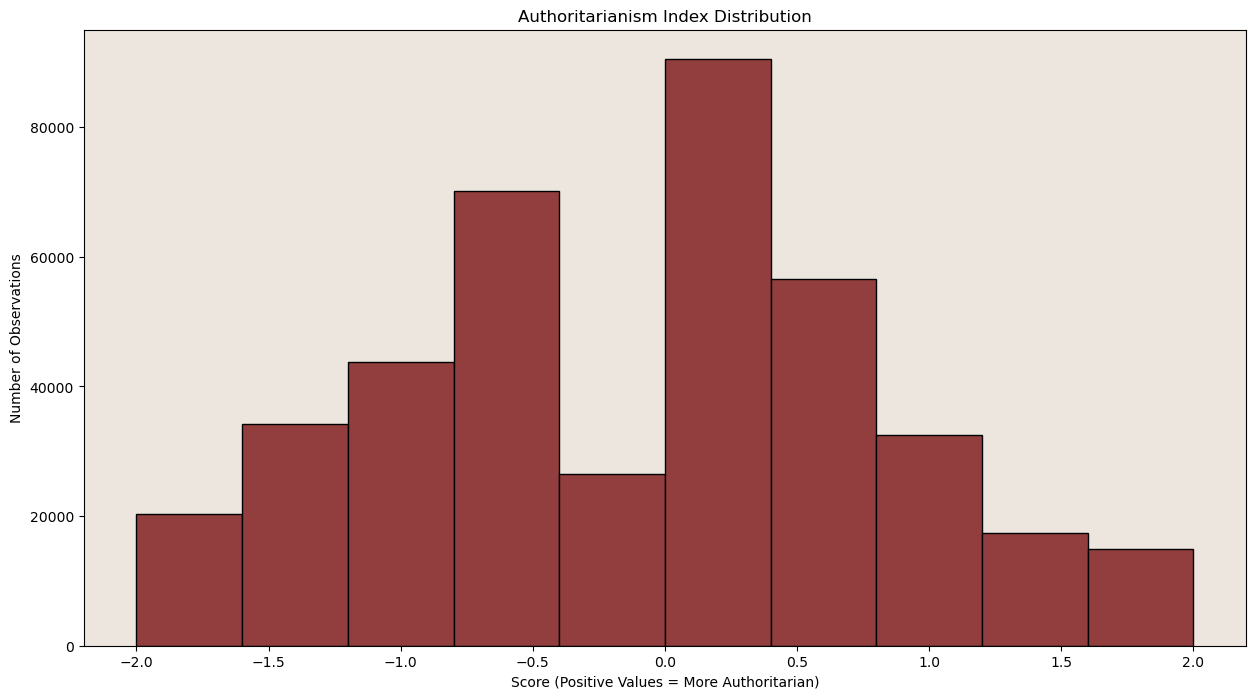

In [64]:
plt.figure(figsize=(15, 8))

plt.hist(wvs_ts['authoritarianism_index'], color='#933e3e', edgecolor='black')

plt.gca().set_facecolor('#ede6de')

plt.xlabel('Score (Positive Values = More Authoritarian)')
plt.ylabel('Number of Observations')
plt.title('Authoritarianism Index Distribution')

;

## Other Potentially Correlated Questions

The questions on the list below do not address **Authoritarianism** directly, but rather concern other values that may be correlated with authoritarian thinking. These will be the X variables for my regression model, and some may be included as secondary variables in my time series model as well. I'll be very interested in which ones correlate most highly with my **Authoritarianism Index**

| Question ID | Question Description | Response Scale | Directionality |
|---|---|---|---|
| A004, A005, A006 | "For each of the following aspects, indicate how important it is in your life" (**Politics, Work, Religion**) | 1 (very important) to 4 (Not at all important) | Negative |
| A008 | "Taking all things together, would you say you are:" (**Happiness**) | 1 (very happy) to 4 (not at all happy) | Negative |
| A029, A030, A032, A034, A035, A039, A040, A041 | "Here is a list of qualities that children can be encouraged to learn at home. Which, if any, do you consider to be especially important? Please choose up to five" (**Independence, Hard work, Feeling of responsibility, imagination, tolerance and respect for other people, determination/perseverance, religious faith, unselfishness**) | 0 (not mentioned) to 1 (important) | Positive |
| A124_02, 03, 06, 07, 08, 09 | "On this list are various groups of people. Could you please mention any that you would not like to have as neighbors?" (**People of a different race, Heavy drinkers, Immigrants/foreign workers, People who have AIDS, Drug addicts, Homosexuals**) | 0 (not mentioned) to 1 (mentioned) | Positive |
| A165 | "Generally speaking, would you say that most people can be trusted or that you need to be very careful in dealing with people?" | 1 (Most people can be trusted) to 2 (Need to be very careful) | Negative |
| A170 | "All things considered, how satisfied are you with your life as a whole these days?" | 1 (Dissatisfied) to 10 (Satisfied) | Positive |
| D054 | "One of my main goals in life has been to make my parents proud" | 1 (Strongly agree) to 4 (Strongly disagree) | Negative |
| D059 | "Men make better political leaders than women do" | 1 (Strongly agree) to 4 (Strongly disagree) | Negative |
| D060 | "University is more important for a boy than for a girl" | 1 (Strongly agree) to 4 (Strongly disagree) | Negative |
| E003 | "If you had to choose, which one of the things on this card would you say is most important?" | **Categorical**: 1 = 'Maintaining order in the nation', 2 = 'Giving people more say in important government decisions', 3 = 'Fighting rising prices', 4 = 'Protecting freedom of speech' | Not Applicable |
| E015, E016 | "I'm going to read out a list of various changes in our way of life that might take place in the near future. Please tell me for each one, if it were to happen, whether you think it would be a good thing, a bad thing, or don't you mind?" (**Less importance placed on work, More emphasis on technology**) | 1 (good thing) to 3 (bad thing) | Negative |
| E023 | "How interested would you say you are in politics?" | 1 (Very interested) to 4 (Not at all interested) | Negative |
| E069_01, 02, 04, 05, 06, 10, 11, 12, 13, 14, 15 | "I am going to name a number of organizations. For each one, could you tell me how much confidence you have in them" (**Churches, Armed Forces, Labour Unions, Police, Television, The Government, Political Parties, Major Companies, Environmental Protection Movement, Women's Movement**) | 1 (A great deal) to 4 (None at all) | Negative |
| F028 | "Apart from weddings, funerals and christenings, about how often do you attend religious services these days?" | 1 (More than once a week) to 8 (Never, practically never) | Negative |
| F063 | "How important is God in your life?" | 1 (Not at all important) to 10 (Very important) | Positive |
| F116, F117, F118, F120, F121, F123 | "Please tell me for each of the following actions whether you think it can always be justified, never be justified, or something in between" (**Cheating on taxes, Someone accepting a bribe, Homosexuality, Abortion, Divorce, Suicide**) | 1 (Never justifiable) to 10 (Always justifiable) | Positive |

***Note**: Response scales are **ordinal** unless otherwise specified*

*Scales determined with reference to https://www.worldvaluessurvey.org/WVSOnline.jsp*

## Demographic Variables

I'll also incorporate some demographic variables into the regression model. Observations in the time series model will be aggregates by year and region of the world, so it won't make sense to use individual demographic data in that model

| Variable ID | Variable Description | Response Scale | Directionality | Model |
|---|---|---|---|---|
| X001 | sex | **Categorical**: 1 = male, 2 = female | NA | Regression |
| X003 | Age (at time of interview) | **Numeric** | NA | Regression |
| X007 | Marital status | **Categorical**: 1 = 'Married', 2 = 'Living together', 3 = 'Divorced', 4 = 'Separated', 5 = 'Widowed', 6 = 'Single' | NA | Regression |
| X011 | Number of children | **Numeric** | NA | Regression |
| X025R | Education level (Recoded into three groups) | 1 (Lower) to 3 (Higher) | Positive | Regression |
| X028 | Employment status | **Categorical**: 1 = 'Full time (> 30hr/wk)', 2 = 'Part time (< 30hr/wk)', 3 = 'Self employed', 4 = 'Retired/pensioned', 5 = 'Housewife not otherwise employed', 6 = 'Student', 7 = 'Unemployed', 8 = 'Other' | NA | Regression |
| X045 | Social class (subjective/self described) | 1 (Upper class) to 5 (Lower class) | Negative | Regression |
| X047R_WVS | Income level (subjective, recoded into three groups) | 1 (low) to 3 (high) | Positive | Regression |
| COUNTRY_ALPHA | Country of Respondent | Categorical: Three-Letter Country Code | NA | Time-Series |
| S002VS | Survey Wave | Numeric | NA | Time-Series |
| S020 | Year of Interview | Numeric/Datetime | NA | Time-Series |

***Note**: Response scales are **ordinal** unless otherwise specified*

*Scales determined with reference to https://www.worldvaluessurvey.org/WVSOnline.jsp*

### Transforming X Variables
I'll do the same two transformations on these variables as I did for the component variables of the **Authoritarianism Index**:
1) Handling Missing Values
2) Standardizing Ordinal Scales

In [35]:
positive_scaled_qs = ['A029', 'A030', 'A032', 'A034', 'A035', 'A039', 'A040', 'A041',
                      'A124_02', 'A124_03', 'A124_06', 'A124_07', 'A124_08', 'A124_09',
                      'A170', 'F063', 'F116', 'F117', 'F118', 'F120', 'F121', 'F123',
                      'X025R', 'X047R_WVS']

negative_scaled_qs = ['A004', 'A005', 'A006', 'A008', 'A165', 'D054', 'D059', 'D060',
                      'E015', 'E016', 'E023', 'E069_01', 'E069_02', 'E069_04', 'E069_05',
                      'E069_06', 'E069_10', 'E069_11', 'E069_12', 'E069_13', 'E069_14',
                      'E069_15', 'F028', 'X045']

all_ordinal_qs = positive_scaled_qs + negative_scaled_qs

non_ordinal_qs = ['E003', 'X001', 'X007', 'X028', 'COUNTRY_ALPHA', 'S002VS', 'S020']

all_qs = all_ordinal_qs + non_ordinal_qs

In [36]:
for q in all_ordinal_qs:
    wvs_ts[q] = missing_to_na(wvs_ts[q])

In [37]:
for q in negative_scaled_qs:
    wvs_ts[q] = scale_adjuster(wvs_ts[q], direction='negative')
    
for q in positive_scaled_qs:
    wvs_ts[q] = scale_adjuster(wvs_ts[q])

In [38]:
wvs_ts['X047R_WVS'].value_counts(dropna=False)

 0.0    224989
-2.0    121502
 2.0     44102
 NaN     16234
Name: X047R_WVS, dtype: int64

## Modelling Dataset

I'll now create my base modelling dataset by combining my two engineered variables ('**region**' and '**authoritarianism_index**') with the other variables I've selected

In [39]:
engineered_vars = ['region', 'authoritarianism_index']
all_vars = engineered_vars + all_qs

wvs_model = wvs_ts[all_vars]

In [40]:
wvs_model.shape

(406827, 57)

In [41]:
wvs_model.to_csv('./data/wvs_model.csv', index=False)

This is the point where the shape of the data for my classification and time-series models will begin to diverge. I'll continue the process of shaping and preparing the data for modelling in the next two notebooks on EDA and data visualization